In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.objective_functions import L2_reg
from pypfopt import HRPOpt
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation, objective_functions
from pypfopt.discrete_allocation import get_latest_prices

In [2]:
INITIAL_CAPITAL = 100000

In [3]:
df = pd.read_csv('Stock Data/stock_data.csv') # reads the stock data CSV file into a pandas dataframe called df
log_returns = pd.DataFrame() # initializes an empty dataframe to store log returns which are just the percent change in an assets value over a certain time period, in this case and most, daily

for column in df.columns: # loops through all the columns in df
    if column != 'Date': # skips the 'Date' column since it doesn't contain numerical data
        df[column] = pd.to_numeric(df[column], errors='coerce') # converts all values in the column to numeric, coercing invalid values into NaN
        log_returns[column] = np.log(df[column] / df[column].shift(1)) # calculates the log returns for each column by dividing the current price by the previous price and taking the natural log

log_returns = log_returns.dropna() # drops any rows that contain NaN values, which might be created during the shift operation

treasury_yield_2yr = pd.read_csv('Macro Data/2yr_treasury_yield.csv') # reads the 2-year treasury yield data from a CSV file
treasury_yield_2yr['DGS2'] = pd.to_numeric(treasury_yield_2yr['DGS2'], errors='coerce') # converts the 'DGS2' column to numeric and coerces invalid values to NaN
treasury_yield_2yr = treasury_yield_2yr.dropna(subset=['DGS2']) # removes rows where 'DGS2' has NaN values

mu = expected_returns.mean_historical_return(df.set_index('Date')) # calculates the mean historical returns for each asset using the Date column as the index
S = risk_models.CovarianceShrinkage(df.set_index('Date')).ledoit_wolf() # calculates the covariance matrix of asset returns using the Ledoit-Wolf shrinkage method for more stability

ef = EfficientFrontier(mu, S) # initializes an Efficient Frontier optimizer using the calculated mean returns and covariance matrix
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # adds L2 regularization to encourage smaller, evenly distributed portfolio weights
ef.max_quadratic_utility(risk_aversion=15) # maximizes the quadratic utility of the portfolio with a given risk aversion level
cleaned_weights = ef.clean_weights() # cleans the portfolio weights, rounding small weights to 0 and ensuring they sum to 1
print("Optimal Weights:", cleaned_weights) # prints the optimal asset weights in the portfolio

expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True) # calculates and prints the expected return, volatility, and Sharpe ratio of the portfolio
latest_prices = get_latest_prices(df.set_index('Date')) # fetches the most recent prices for all assets in the dataframe
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=INITIAL_CAPITAL) # uses the cleaned weights and latest prices to calculate the discrete number of shares to buy for each asset
allocation, leftover = da.lp_portfolio() # allocates shares using linear programming and calculates the leftover cash

print("\Distribution of Shares:") # prints the header for the allocation of shares
for stock, num_shares in allocation.items(): # loops through each stock in the allocation and prints the number of shares and the percentage of total capital allocated to it
    weight_percentage = cleaned_weights[stock] * 100 # calculates the percentage of total capital allocated to each stock
    print(f"{stock}: {num_shares} shares ({weight_percentage:.2f}%)") # prints the stock symbol, number of shares, and the weight percentage

print(f"\nLeftover cash after allocation: ${leftover:.2f}") # prints the amount of leftover cash after making the allocations


<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/var/folders/sf/l3v9l9vs0sj1f8h2p4fnlsd00000gn/T/ipykernel_95771/111419568.py:29: SyntaxWarning: invalid escape sequence '\D'
  print("\Distribution of Shares:") # prints the header for the allocation of shares


Optimal Weights: OrderedDict({'Stock A': 0.0, 'Stock B': 0.10973, 'Stock C': 0.0, 'Stock D': 0.0, 'Stock E': 0.0, 'Stock F': 0.07472, 'Stock G': 0.30433, 'Stock H': 0.0, 'Stock I': 0.0, 'Stock J': 0.27042, 'Stock K': 0.2408})
Expected annual return: 19.5%
Annual volatility: 22.1%
Sharpe Ratio: 0.79
\Distribution of Shares:
Stock B: 141 shares (10.97%)
Stock F: 43 shares (7.47%)
Stock G: 394 shares (30.43%)
Stock J: 192 shares (27.04%)
Stock K: 118 shares (24.08%)

Leftover cash after allocation: $14.57


[*********************100%***********************]  1 of 1 completed


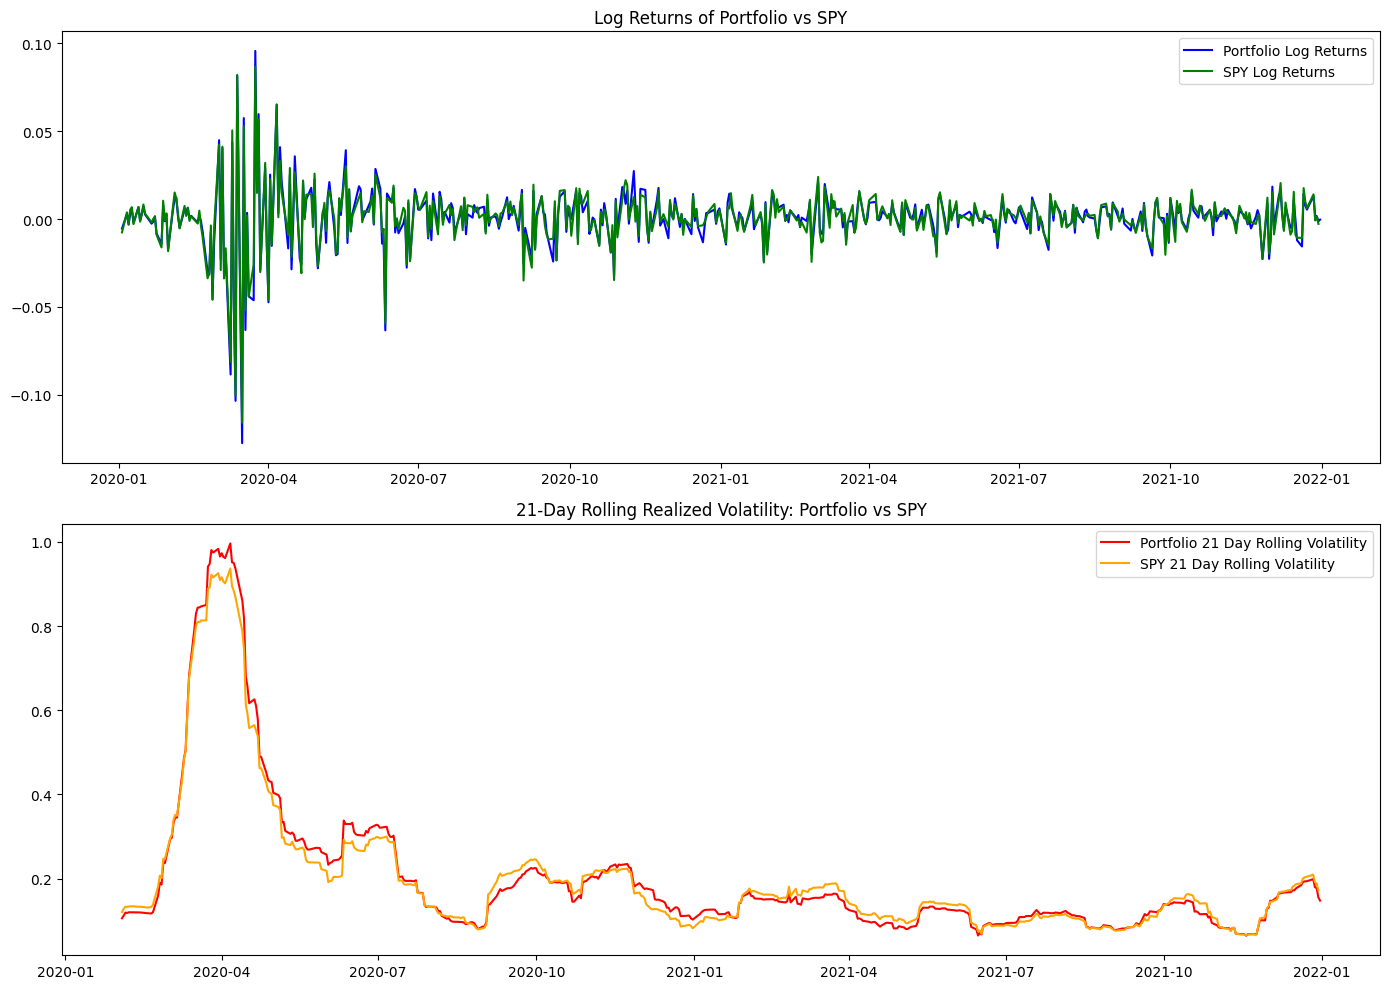

In [4]:
df['Date'] = pd.to_datetime(df['Date']) # converts the whole 'Date' column from the data frame we defined in part 1 to datetime format in order for easier use

df.set_index('Date', inplace=True) # sets the index column for the data fram as 'Date' (inplace=True was chatgpt) in order to reference this column later on 

log_returns = np.log(df / df.shift(1)) # finds the log return values of the data by dividing the closing row by the row below it in the data, and then taking the natural log for every row in the dataframe
start_date = df.index.min() # earliest start date to use for SPY metrics
end_date = df.index.max() # latest start date to use for SPY metrics
spy_data = yf.download('SPY', start=start_date, end=end_date) # uses yfinance to download SPY's data and graph from the start and end time we just defined

spy_data['SPY_log_returns'] = np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1)) # find the log return values for SPY using the same method applied onto the dataframe for the stock data
spy_data = spy_data.dropna() # drops any NaN values that are formed in the first row due to the shifting of the rows

portfolio_log_returns = log_returns.mean(axis=1) # calculates the mean log returns of the portfolio for each day by averaging the log returns across all stocks (axis=1 means it averages across columns for each row)
portfolio_rolling_volatility = portfolio_log_returns.rolling(window=21).std() * np.sqrt(252) # calculates the 21 day rolling volatility for the portfolio log returns (which is then annualized by multiplying it by sqrt(252) which is the sqrt(number of trading days in a year))
spy_rolling_volatility = spy_data['SPY_log_returns'].rolling(window=21).std() * np.sqrt(252) # similarly, calculates the 21 day rolling volatility for SPY's log returns, with the same 21 day window and annualization process

plt.figure(figsize=(14, 10)) # creates a new figure for plotting with a specified size of 14x10 inches
plt.subplot(2, 1, 1) # creates the first subplot in a 2 by 1 row column layout for plotting the log returns comparison
plt.plot(df.index, portfolio_log_returns, label="Portfolio Log Returns", color="blue") # plots the portfolio's log returns against the dates from the data frame, using blue color and labeling it "Portfolio Log Returns"
plt.plot(spy_data.index, spy_data['SPY_log_returns'], label="SPY Log Returns", color="green") # plots SPY's log returns using its dates, with green color and labeling it "SPY Log Returns"
plt.title("Log Returns of Portfolio vs SPY") # adds the title for the first plot, describing the comparison of log returns between the portfolio and SPY
plt.legend() # adds a legend to identify the different lines on the first plot (Portfolio vs SPY log returns)
plt.subplot(2, 1, 2) # creates the second subplot in the 2 by 1 row column layout for plotting the rolling volatility comparison.
plt.plot(df.index, portfolio_rolling_volatility, label="Portfolio 21 Day Rolling Volatility", color="red") # plots the 21 day rolling volatility of the portfolio against the dates, using red color and labeling it "Portfolio 21 Day Rolling Volatility"
plt.plot(spy_data.index, spy_rolling_volatility, label="SPY 21 Day Rolling Volatility", color="orange") # plots SPY's 21-day rolling volatility against its dates, using orange color and labeling it "SPY 21 Day Rolling Volatility"
plt.title("21-Day Rolling Realized Volatility: Portfolio vs SPY") # adds the title for the second plot, describing the comparison of 21-day rolling volatility between the portfolio and SPY
plt.legend() # adds a legend to identify the different lines on the second plot (Portfolio vs SPY rolling volatility)
plt.tight_layout() # ensures the subplots of the layout are properly spaced and do not overlap with each other
plt.show() # plots the graph with both subplots showing the log returns and volatility comparisons between the portfolio and SPY